In [6]:
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt

# 원본 데이터 로드
train_origin = pd.read_csv('/Users/jaesolshin/내 드라이브/2024-2/Google ML Bootcamp2024/data/playground1/train.csv')

# 데이터 샘플링
train_origin = train_origin.sample(frac=0.1, random_state = 42)

# 예측에 필요 없는 'id'와 'Annual_Premium' 변수를 드롭
train_origin = train_origin.drop(columns=['id'])

# 범주형 변수 인코딩
def encoding(train):
    gender_mapping = {'Male': 0, 'Female': 1}
    vehicle_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
    vehicle_damage_mapping = {'No': 0, 'Yes': 1}

    train['Gender'] = train['Gender'].map(gender_mapping)
    train['Vehicle_Age'] = train['Vehicle_Age'].map(vehicle_age_mapping)
    train['Vehicle_Damage'] = train['Vehicle_Damage'].map(vehicle_damage_mapping)

    return train

train_origin = encoding(train_origin)

# 범주형 변수 타겟 인코딩
cat_columns = ['Region_Code', 'Policy_Sales_Channel', 'Vintage']
train_origin.loc[:,cat_columns] = train_origin.loc[:,cat_columns].astype('category')

target_encoder = TargetEncoder()
train_origin[cat_columns] = target_encoder.fit_transform(train_origin[cat_columns],train_origin['Response'])

#수치형 변수: Age, Region_Code, Annual Premium, Policy_Sales_Channel, Vintage -> normalize
scaler = MinMaxScaler()
num_columns = ['Age', 'Annual_Premium']
train_origin[num_columns] = scaler.fit_transform(train_origin[num_columns])

# XGBoost에서 발생하는 문제 해결
train_origin.columns = train_origin.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')

In [ ]:
# 샘플 비율
fractions = np.logspace(-3, 0, num=9)

# 결과 저장용 데이터프레임
results = pd.DataFrame(columns=["Model", "Sample Size", "Fold", "ROC-AUC", "Training Time"])

# KFold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for frac in fractions:
    train = train_origin.sample(frac=frac, random_state=42)
    X = train.drop(['Response'], axis=1)
    y = train['Response']
    
    sample_size = len(X)
    
    models = {
        "RandomForest": RandomForestClassifier(),
        "CatBoost": CatBoostClassifier(verbose=0),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "LightGBM": LGBMClassifier()
    }
    
    for model_name, model in models.items():
        fold_idx = 1
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            y_pred = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_pred)
            
            # 새로운 행 데이터
            new_row = {
                "Model": model_name,
                "Sample Size": sample_size,
                "Fold": fold_idx,
                "ROC-AUC": roc_auc,
                "Training Time": training_time
            }

            # 새로운 행을 데이터프레임으로 변환
            new_row_df = pd.DataFrame([new_row])

            # pd.concat을 사용하여 새로운 행 추가
            results = pd.concat([results, new_row_df], ignore_index=True)
            
            print(f"Model: {model_name}, Sample Size: {sample_size}, Fold: {fold_idx}, ROC-AUC: {roc_auc:.4f}, Training Time: {training_time:.2f} seconds")
            
            fold_idx += 1

In [9]:
print(results)

            Model Sample Size Fold   ROC-AUC  Training Time
0    RandomForest        1150    1  0.857762       0.498251
1    RandomForest        1150    2  0.839925       0.389835
2    RandomForest        1150    3  0.868374       0.277450
3    RandomForest        1150    4  0.906655       0.277876
4    RandomForest        1150    5  0.816141       0.260263
..            ...         ...  ...       ...            ...
175      LightGBM      115048    1  0.874444       1.112186
176      LightGBM      115048    2  0.871984       0.815169
177      LightGBM      115048    3  0.875619       0.714362
178      LightGBM      115048    4  0.874621       0.684940
179      LightGBM      115048    5  0.872938       1.027075

[180 rows x 5 columns]


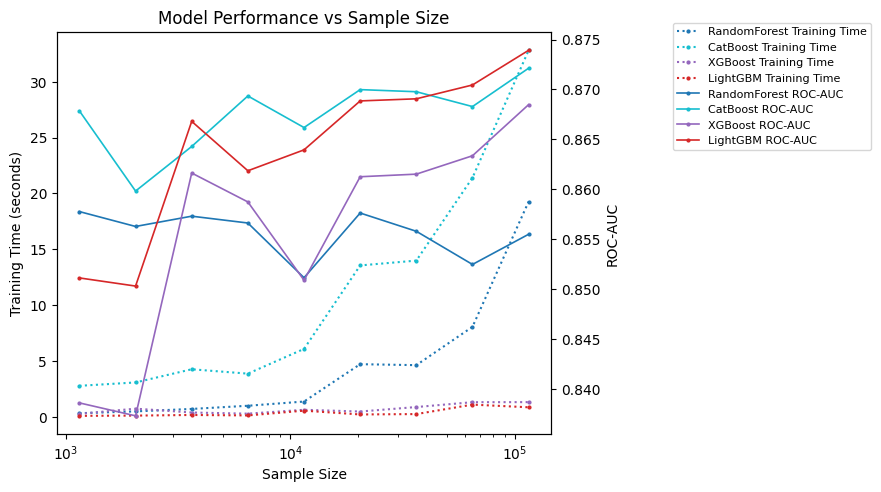

In [52]:
import matplotlib.pyplot as plt

# 색상 지정
colors = {
    "RandomForest": 'tab:blue',
    "CatBoost": 'tab:cyan',
    "XGBoost": 'tab:purple',
    "LightGBM": 'tab:red'
}

# 결과 시각화
fig, ax2 = plt.subplots()

ax2.set_xlabel('Sample Size')
ax2.set_ylabel('Training Time (seconds)')
for model_name in results["Model"].unique():
    mean_training_time = results[results["Model"] == model_name].groupby("Sample Size")["Training Time"].mean()
    ax2.plot(mean_training_time.index,
             mean_training_time,
             label=f'{model_name} Training Time', color=colors[model_name], linestyle=':', linewidth=1.5, marker='o', markersize=2)
ax2.tick_params(axis='y')
ax2.set_xscale('log')  # x축을 로그 스케일로 설정

ax1 = ax2.twinx()
ax1.spines['left'].set_position(('outward', 0))
ax1.yaxis.set_label_position('right')
ax1.yaxis.set_ticks_position('right')
ax1.set_ylabel('ROC-AUC')
for model_name in results["Model"].unique():
    mean_roc_auc = results[results["Model"] == model_name].groupby("Sample Size")["ROC-AUC"].mean()
    ax1.plot(mean_roc_auc.index,
             mean_roc_auc,
             label=f'{model_name} ROC-AUC', color=colors[model_name], linestyle='-', linewidth=1.2, marker='o', markersize=2)
ax1.tick_params(axis='y')

fig.tight_layout()
plt.title('Model Performance vs Sample Size')

# 범례를 그래프 바깥으로 배치하고 글씨 크기를 작게 설정
fig.legend(loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 8})
plt.show()